In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!unzip /content/gdrive/MyDrive/BP_data/archive.zip

Archive:  /content/gdrive/MyDrive/BP_data/archive.zip
  inflating: Samples/rec_1.csv       
  inflating: Samples/rec_10.csv      
  inflating: Samples/rec_100.csv     
  inflating: Samples/rec_101.csv     
  inflating: Samples/rec_102.csv     
  inflating: Samples/rec_103.csv     
  inflating: Samples/rec_104.csv     
  inflating: Samples/rec_105.csv     
  inflating: Samples/rec_106.csv     
  inflating: Samples/rec_107.csv     
  inflating: Samples/rec_108.csv     
  inflating: Samples/rec_109.csv     
  inflating: Samples/rec_11.csv      
  inflating: Samples/rec_110.csv     
  inflating: Samples/rec_111.csv     
  inflating: Samples/rec_112.csv     
  inflating: Samples/rec_113.csv     
  inflating: Samples/rec_114.csv     
  inflating: Samples/rec_115.csv     
  inflating: Samples/rec_116.csv     
  inflating: Samples/rec_117.csv     
  inflating: Samples/rec_118.csv     
  inflating: Samples/rec_119.csv     
  inflating: Samples/rec_12.csv      
  inflating: Samples/rec_120.csv  

In [ ]:
import pandas as pd
import numpy as np
import cv2
import os
from pathlib import Path
import glob
import os
import cv2
import matplotlib.pyplot as plt

In [ ]:
# importing libraries
import numpy as np # For numerical computation
import pandas as pd # Data manipulation
import seaborn as sns # plotting
import scipy.io # reading matlab files in python
from scipy import signal #signal processing
from scipy.fftpack import fft, dct #signal processing

from sklearn.linear_model import LinearRegression #linear regression model
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold, train_test_split # cross validation split
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings('ignore')

from matplotlib import pyplot as plt # For plotting graphs(Visualization)

import os # system-wide functions


In [ ]:
sample_file = scipy.io.loadmat(f'/content/part_1.mat')
print(f'sample_file Data type: {type(sample_file)}')
print(f'sample_file keys:\n{sample_file.keys()}')

sample_file Data type: <class 'dict'>
sample_file keys:
dict_keys(['__header__', '__version__', '__globals__', 'p'])


In [ ]:
# Loading a sample .mat file to understand the data dimensions
test_sample = scipy.io.loadmat(f'/content/part_1.mat')['p']
print(f'test_sample Data type: {type(test_sample)}')
print(f'test_sample shape/dimensions: {test_sample.shape}')

test_sample Data type: <class 'numpy.ndarray'>
test_sample shape/dimensions: (1, 1000)


In [ ]:
print(f"Total Samples: {len(test_sample[0])}")
print(f"Number of readings in each sample(column): {len(test_sample[0][0])}")
print(f"Number of samples in each reading(ECG): {len(test_sample[0][0][2])}")

temp_mat = test_sample[0, 999]
temp_length = temp_mat.shape[1]
sample_size = 125


print(temp_length)
print((int)(temp_length/sample_size))

Total Samples: 1000
Number of readings in each sample(column): 3
Number of samples in each reading(ECG): 61000
9000
72


In [ ]:
temp_mat.shape

(3, 9000)

In [ ]:
sample_size = 125
ppg = []
for i in range(1000):
    temp_mat = test_sample[0, i]
    temp_length = temp_mat.shape[1]
    for j in range((int)(temp_length/sample_size)):
        temp_ppg = temp_mat[0, j*sample_size:(j+1)*sample_size]
        ppg.append(temp_ppg)

In [ ]:
ecg = []
bp = []
sbp = [] #Systolic Blood Pressure
dbp = [] #Diastolic Blood Pressue
size = 125 #sample size

for i in range(1000):
    temp_mat = test_sample[0, i]
    temp_length = temp_mat.shape[1]
    for j in range((int)(temp_length/sample_size)):
        temp_ecg = temp_mat[2, j*size:(j+1)*size]
        temp_bp = temp_mat[1, j*size:(j+1)*size]
        
        max_value = max(temp_bp)
        min_value = min(temp_bp)
        
        sbp.append(max_value)
        dbp.append(min_value)
        ecg.append(temp_ecg)
        bp.append(temp_bp)

In [ ]:
# Reshaping the ecg, ppg and bp signal data into column vectors
ppg, ecg, bp = np.array(ppg).reshape(-1,1), np.array(ecg).reshape(-1,1), np.array(bp).reshape(-1,1)
sbp, dbp = np.array(sbp).reshape(-1,1), np.array(dbp).reshape(-1,1)
print(f'PPG_shape: {ppg.shape}\n ECG_shape: {ecg.shape}\n BP_shape: {bp.shape}')
print(f'Systolic-BP_shape: {sbp.shape},\n Diastolic-BP_shape: {dbp.shape}')

PPG_shape: (32061000, 1)
 ECG_shape: (32061000, 1)
 BP_shape: (32061000, 1)
Systolic-BP_shape: (256488, 1),
 Diastolic-BP_shape: (256488, 1)


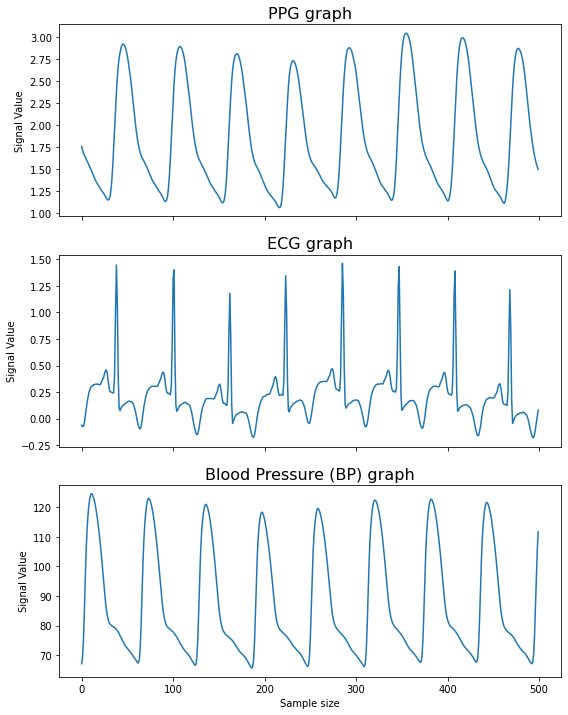

In [ ]:
##plotting sample ppg, ecg and bp signals
##using a sample size of 500
fig, ax = plt.subplots(3,1, figsize=(9,12), sharex=True)

ax[0].set_title('PPG graph', fontsize=16)
ax[0].set_ylabel('Signal Value')
ax[0].plot(ppg[:500])

ax[1].set_title('ECG graph', fontsize=16)
ax[1].set_ylabel('Signal Value')
ax[1].plot(ecg[:500])

ax[2].set_title('Blood Pressure (BP) graph', fontsize=16)
ax[2].set_ylabel('Signal Value')
ax[2].set_xlabel('Sample size')
ax[2].plot(bp[:500])

In [ ]:
Map=(sbp+ (2*dbp))/3

Text(0, 0.5, 'Map')

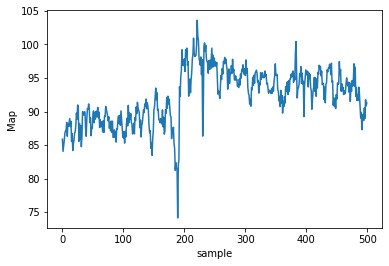

In [ ]:
plt.plot(Map[:500])
plt.xlabel("sample")
plt.ylabel("Map")

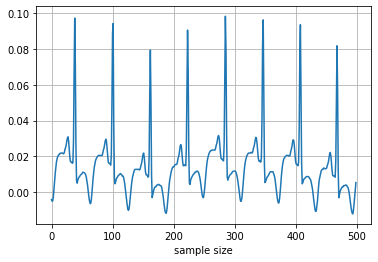

In [ ]:
from scipy.signal import butter, lfilter

def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a


def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y


def run():
    import numpy as np
    import matplotlib.pyplot as plt
    from scipy.signal import freqz

    # Sample rate and desired cutoff frequencies (in Hz).
    fs = 500.0
    lowcut = 0.1
    highcut = 50.0
    y = butter_bandpass_filter(ecg, lowcut, highcut, fs, order=2)
    plt.plot(y[:500])
    plt.xlabel('sample size')
    plt.grid(True)

    plt.show()


run()

In [ ]:
fs = 500.0
lowcut = 0.1
highcut = 50.0
ecg_new=butter_bandpass_filter(ecg, lowcut, highcut, fs, order=2)

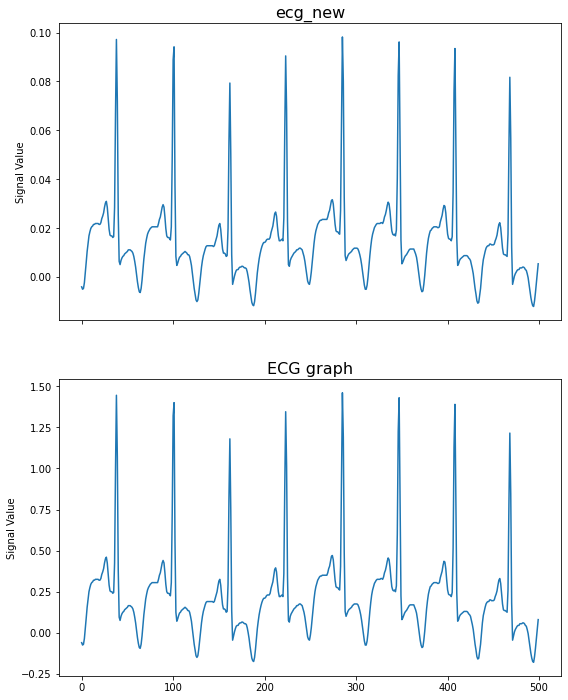

In [ ]:
fig, ax = plt.subplots(2,1, figsize=(9,12), sharex=True)

ax[0].set_title('ecg_new', fontsize=16)
ax[0].set_ylabel('Signal Value')
ax[0].plot(ecg_new[:500])

ax[1].set_title('ECG graph', fontsize=16)
ax[1].set_ylabel('Signal Value')
ax[1].plot(ecg[:500])

In [ ]:
pip install neurokit2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.2 MB 5.2 MB/s 


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.signal
import scipy.stats
import neurokit2 as nk

In [ ]:
ecg_new.shape

(32061000, 1)

In [ ]:
ecg_new=ecg_new.reshape(len(ecg_new))

In [ ]:
bp=bp.reshape(len(bp))

In [ ]:
ecg_new.shape

(32061000,)

In [ ]:
bp.shape

(32061000,)

In [ ]:
_, rpeaks = nk.ecg_peaks(ecg_new, sampling_rate=50)

In [ ]:
rpeaks

{'ECG_R_Peaks': array([      38,      101,      162, ..., 32060824, 32060871, 32060945]),
 'sampling_rate': 50}

In [ ]:
len(rpeaks.values())

2

In [ ]:
a=[]
for i in rpeaks.values():
  a.append(i)

In [ ]:
a

[array([      38,      101,      162, ..., 32060824, 32060871, 32060945]), 50]

In [ ]:
peak=[]
peak=a[0]

In [ ]:
peak

array([      38,      101,      162, ..., 32060824, 32060871, 32060945])

In [ ]:
len(peak)

400011

In [ ]:
ecg_new.shape

(32061000,)

In [ ]:
all_peaks=[]
corr_bp=[]
i=0
while i+3<len(peak):
  j=peak[i]
  k=peak[i+3]
  temp=ecg_new[j:k+1]
  b=bp[j:k+1]
  all_peaks.append(temp)
  corr_bp.append(b)
  i+=4


In [ ]:
len(all_peaks)

100002

In [ ]:
len(corr_bp)

100002

In [ ]:
new_data=np.array(all_peaks)

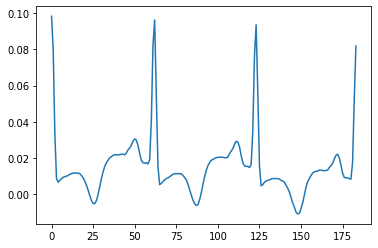

In [ ]:
plt.plot(all_peaks[1])

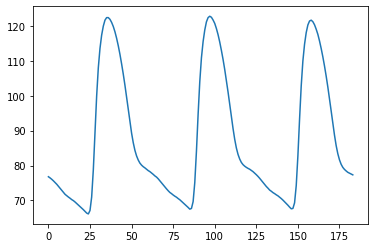

In [ ]:
plt.plot(corr_bp[1])

In [ ]:
from scipy import signal
from scipy.fft import fft, fftfreq, fftshift
import scipy.fft
f=scipy.signal.resample(all_peaks[1], 120)
b=scipy.signal.resample(corr_bp[1], 120)


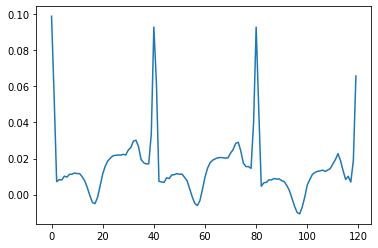

In [ ]:
plt.plot(f)

In [ ]:
f_peak=[]
f_bp=[]
for i in range(len(all_peaks)):
    f=scipy.signal.resample(all_peaks[i], 120)
    b=scipy.signal.resample(corr_bp[i], 120)
    f_peak.append(f);
    f_bp.append(b)


In [ ]:
f_peak=np.array(f_peak)
f_bp=np.array(f_bp)

In [ ]:
f_peak.shape

(100002, 120)

In [ ]:
f_bp.shape

(100002, 120)

In [ ]:
peak_sbp=[]
peak_dbp=[]
for i in f_bp:
  peak_sbp.append(max(i))
  peak_dbp.append(min(i))

In [ ]:
peak_sbp=np.array(peak_sbp)
peak_dbp=np.array(peak_dbp)

In [ ]:
peak_sbp.shape

(100002,)

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(f_peak,peak_sbp, test_size=0.33)

In [ ]:
from sklearn.ensemble import AdaBoostRegressor
from sklearn.model_selection import KFold, train_test_split # cross validation split
from sklearn.metrics import mean_squared_error

In [ ]:
def rmse(y_true, y_pred):
    """Computes the Root Mean Squared Error (RMSE)."""
    return np.sqrt(mean_squared_error(y_true, y_pred))

In [ ]:
from sklearn.metrics import mean_absolute_error

In [ ]:
folds = KFold(n_splits=5, shuffle=False)
scores = []
for i, (train_index, val_index) in enumerate(folds.split(X_train, y_train)):
    train_data, target = X_train[train_index], y_train[train_index]
    validation_data, val_target = X_train[val_index], y_train[val_index]
    
    model = AdaBoostRegressor(random_state=1, n_estimators=100)
    model.fit(train_data, target)
    #model = RandomForestRegressor(n_estimators=50,max_depth=5, n_jobs=-1, random_state=42)
    #model.fit(train_data[:100000], target[:100000].squeeze())  # training on few samples to save time.
    val_predictions_sbp = model.predict(validation_data)
    error = rmse(val_target, val_predictions_sbp)
    scores.append(error)
    print(f'Fold {i} RMSE: {error}')
print(f'Average RMSE over 5 folds: {np.mean(scores)}')

Fold 0 RMSE: 19.823347740146325
Fold 1 RMSE: 19.572504843803408
Fold 2 RMSE: 19.812434364371832
Fold 3 RMSE: 19.896830359090465
Fold 4 RMSE: 19.434381804431563
Average RMSE over 5 folds: 19.70789982236872


In [ ]:
# from sklearn.ensemble import AdaBoostRegressor
# regr = AdaBoostRegressor(random_state=1, n_estimators=100,loss='exponential')
# regr.fit(X_train, y_train)

In [ ]:
# x=regr.predict(X_test)

In [ ]:
# plt.scatter(X_test,y_test)
# plt.scatter(X_test,x)

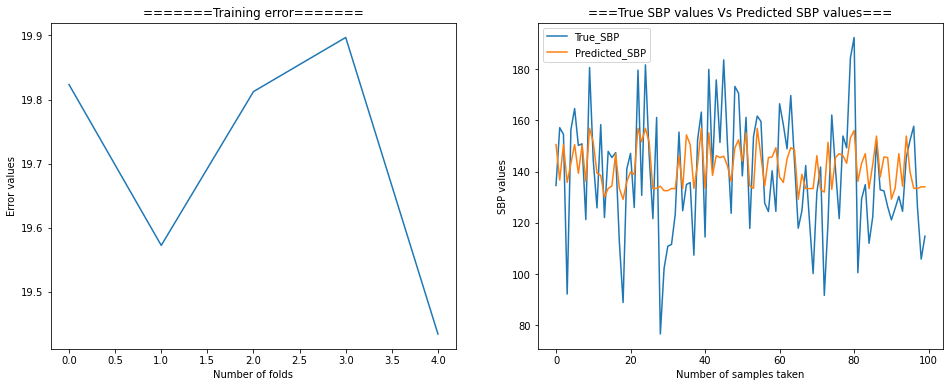

In [ ]:
fig, ax = plt.subplots(1,2, figsize=(16,6))
ax[0].set_title("=======Training error=======")
ax[0].set_xlabel('Number of folds')
ax[0].set_ylabel('Error values')
ax[0].plot(scores)

# Visualize predicted BP and the True BP
ax[1].set_title("===True SBP values Vs Predicted SBP values===")
ax[1].set_xlabel('Number of samples taken')
ax[1].set_ylabel('SBP values')
ax[1].plot(val_target[:100]) #only plotting 100 samples
ax[1].plot(val_predictions_sbp[:100])
ax[1].legend(['True_SBP', 'Predicted_SBP'])

In [ ]:
mean_absolute_error(val_target, val_predictions_sbp)

15.81190384951523

In [ ]:
print(val_predictions_sbp)

[150.59865442 136.72465755 150.59865442 ... 138.47110909 143.25702377
 135.83500088]


#DBP



In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(f_peak,peak_dbp, test_size=0.33)

In [ ]:
folds = KFold(n_splits=5, shuffle=False)
scores = []
for i, (train_index, val_index) in enumerate(folds.split(X_train, y_train)):
    train_data, target = X_train[train_index], y_train[train_index]
    validation_data, val_target = X_train[val_index], y_train[val_index]
    
    model_dbp = AdaBoostRegressor(random_state=1, n_estimators=100)
    model_dbp.fit(train_data, target)
    #model = RandomForestRegressor(n_estimators=50,max_depth=5, n_jobs=-1, random_state=42)
    #model.fit(train_data[:100000], target[:100000].squeeze())  # training on few samples to save time.
    val_predictions_dbp = model_dbp.predict(validation_data)
    error = rmse(val_target, val_predictions_dbp)
    scores.append(error)
    print(f'Fold {i} RMSE: {error}')
print(f'Average RMSE over 5 folds: {np.mean(scores)}')

Fold 0 RMSE: 22.466288417126353
Fold 1 RMSE: 17.577961989303656
Fold 2 RMSE: 23.42405752291739
Fold 3 RMSE: 22.403080708086623
Fold 4 RMSE: 21.979546800494596
Average RMSE over 5 folds: 21.570187087585726


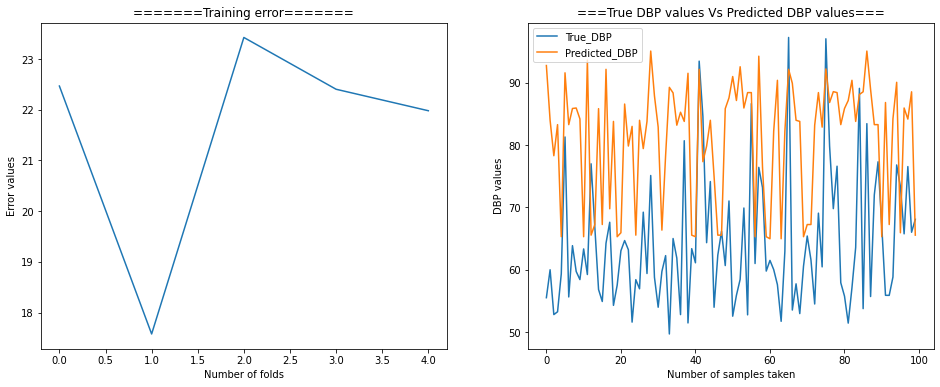

In [ ]:
fig, ax = plt.subplots(1,2, figsize=(16,6))
ax[0].set_title("=======Training error=======")
ax[0].set_xlabel('Number of folds')
ax[0].set_ylabel('Error values')
ax[0].plot(scores)

# Visualize predicted BP and the True BP
ax[1].set_title("===True DBP values Vs Predicted DBP values===")
ax[1].set_xlabel('Number of samples taken')
ax[1].set_ylabel('DBP values')
ax[1].plot(val_target[:100]) #only plotting 100 samples
ax[1].plot(val_predictions_dbp[:100])
ax[1].legend(['True_DBP', 'Predicted_DBP'])

In [ ]:
mean_absolute_error(val_target, val_predictions_dbp)

19.299382262678787

In [ ]:
print(val_predictions_dbp)

[92.76639476 83.98731791 78.30144346 ... 69.179217   94.49006745
 83.98731791]


In [ ]:
health_condition = []
category = ["Normal", "Prehypertension", "Hypertension"]
for i in range(len(val_predictions_sbp)):
  if (val_predictions_sbp[i] <= 90 or val_predictions_dbp[i] <= 60):
    health_condition.append(category[0])
  if ((val_predictions_sbp[i] >= 90 and val_predictions_sbp[i] < 120) and (val_predictions_dbp[i] >= 60 and val_predictions_dbp[i] < 79)):
    health_condition.append(category[0])
  if ((val_predictions_sbp[i] >= 120 and val_predictions_sbp[i] < 140) or (val_predictions_dbp[i] >= 80 and val_predictions_dbp[i] < 90)):
    health_condition.append(category[1])
  if ((val_predictions_sbp[i] >= 140 and val_predictions_sbp[i] < 160) or (val_predictions_dbp[i] >= 90 and val_predictions_dbp[i] < 100)):
    health_condition.append(category[2])
  if (val_predictions_sbp[i] >= 160 or val_predictions_dbp[i] >= 100):
    health_condition.append(category[2])
  if (val_predictions_sbp[i] >= 140 and val_predictions_dbp[i] < 90):
    health_condition.append(category[2])
  if (val_predictions_sbp[i] >= 180 or val_predictions_dbp[i] >= 110):
    health_condition.append(category[2])

In [ ]:
health_condition = np.array(health_condition)
print(health_condition)

['Hypertension' 'Prehypertension' 'Hypertension' ... 'Prehypertension'
 'Hypertension' 'Prehypertension']
